# Capstone Project: Classifying clinically actionable genetic mutations

***

## Notebook 4: Alternative Models

This notebook contains code to explore alternative models to address the classification problem.

### Contents

- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)

## Importing of Libraries

In [1]:
import pandas as pd
import numpy as np

from tabulate import tabulate
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict

TRAIN_SET_PATH = "../assets/train_prep.csv"

GLOVE_6B_50D_PATH = "../assets/glove.6B.50d.txt"
GLOVE_6B_300D_PATH = "../assets/glove.6B.300d.txt"
encoding="utf-8"

BERT_INIT_CHKPNT = "../assets/cased_L-12_H-768_A-12/bert.model.ckpt.index"
BERT_VOCAB = "../assets/cased_L-12_H-768_A-12/vocab.txt"
BERT_CONFIG = "../assets/cased_L-12_H-768_A-12/bert_config.json"

from sklearn import linear_model
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import nltk
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.callbacks import EarlyStopping

import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
# import tensorflow as tf
import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
import tensorflow_hub as hub

from wordcloud import WordCloud

import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Initialise random seeed for more consistent results
from numpy.random import seed
seed(42)

Using TensorFlow backend.


## Data Import

In [2]:
# Import 'train_prep' and 'test_prep' datasets
# We use the 'keep_default_na' option to False to ensure that pandas does not re-introduce missing values
train = pd.read_csv("../assets/train_prep.csv", keep_default_na=False)
test = pd.read_csv("../assets/test_prep.csv", keep_default_na=False)

In [3]:
train.shape, test.shape

((3321, 4325), (986, 4324))

In [4]:
train.head(2)

,id,class,text,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,...,variation_YAP1-TFE3 Fusion,variation_YWHAE-ROS1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_null1313Y,variation_null189Y,variation_null262Q,variation_null267R,variation_null399R,variation_p61BRAF
0,0,1,cyclin dependent kinase cdks regulate variety ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,abstract background non small lung nsclc heter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head(2)

,id,text,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,gene_AGXT,...,variation_YAP1-TFE3 Fusion,variation_YWHAE-ROS1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_null1313Y,variation_null189Y,variation_null262Q,variation_null267R,variation_null399R,variation_p61BRAF
0,1,incidence breast increase china recent decade ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,unselected series colorectal carcinoma stratif...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Preparation for Modelling

In [6]:
# Splitting of data into Predictor (X) and Target (y) Dataframes
X = train[[i for i in train.columns if i not in ['id', 'class']]]
y = train['class']

In [7]:
X.shape, y.shape

((3321, 4323), (3321,))

In [8]:
# Save copies of the original X and y dataframes so that we can try different word embeddings as needed
X_original = X.copy()
y_original = y.copy()

In [9]:
X_test = test.drop(['id'], axis=1)

In [10]:
X_test.shape

(986, 4323)

In [11]:
%%time
# For convenience, we create an array called 'X_all_text that contains
# all the text from our training set, across all data points
X_all_text = []
for text in X['text']:
    X_all_text.append(text.split())
X_all_text = np.array(X_all_text)

Wall time: 10 s


In [12]:
X_all_text.shape

(3321,)

## Evaluation of Alternative Models based on Static Word Embeddings

In this section, we evaluate alternative models that are based on static word embeddings, which are word embeddings that do not take any context of use into account.

Our alternative model has three components:
- Static word embeddings
- Vectorizer
- Classifier

**Evaluation Approach**

Given that it would be computationally infeasible to evaluate all possible combinations of the above, we instead find the best alternative model based on the following order:
1. Find the best combination of static word embeddings and vectorizer
2. Find the best classifier

For **Step 1** above, we explore three alternative static word embeddings to see if we can get better classification results:
- GloVe (Global Vectors for Word Representation) pre-trained word embeddings based on Wikipedia 2015 and Gigaword 5th Edition (https://catalog.ldc.upenn.edu/LDC2011T07) - we create a dictionary called 'glove_small' for these word embeddings.
- GloVe pre-trained word embeddings based on Common Crawl (https://commoncrawl.org/) - we create a dictionary called 'glove_big' for these word embeddings.
- Our own word embeddings created by training Word2Vec (from nltk) on all the given text in the training dataset - we create a dictionary called 'w2v' for these word embeddings.

The GloVe word embeddings are created by the [Stanford Natural Language Processing Group](https://nlp.stanford.edu/) and are available at https://nlp.stanford.edu/projects/glove/.

For **Step 2** above, we evaluate the performance of a Forward Neural Network (FNN) and an Extra Trees Classifier.

### Loading of pre-trained word embeddings based on GloVe

We now load the two pre-trained word embeddings (based on GloVe) and store them as dictionary objects 'glove_small' and 'glove_big'.

In [13]:
%%time
import struct 

# glove_small keys are bounded by what is common to both the X_all_text and the glove file
glove_small = {}
all_words = set(w for words in X_all_text for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

# glove_big keys are bounded by what is common to both the X_all_text and the glove file
glove_big = {}
with open(GLOVE_6B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if word in all_words:
            nums=np.array(parts[1:], dtype=np.float32)
            glove_big[word] = nums

Wall time: 32.8 s


### Loading of pre-trained word embeddings based on ELMo

<img src="../assets/elmo.jpg" alt="Drawing" style="width: 700px;"/>

In [35]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

INFO:absl:Using C:\Users\yuchy\AppData\Local\Temp\tfhub_modules to cache modules.


In [246]:
# We define a function to take the mean of the ELMo vectors of constituent terms or tokens of the descriptive text.
def elmo_vectors(x):
    embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        # return average of ELMo features
        return sess.run(tf.reduce_mean(embeddings,1))

In [ ]:
list_train = [X_all_text[i:i+100] for i in range(0,X_all_text.shape[0],100)]

In [ ]:
%%time
# Extract ELMo embeddings
elmo_train = [elmo_vectors(x)]

### Creation of word embeddings based on training set vocabulary

We now create our own word embeddings using Word2Vec from nltk, trained using all the text in the training dataset.

In [14]:
%%time
model = Word2Vec(X_all_text, size=100, window=5, min_count=5, workers=8)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

Wall time: 2min 20s


In [15]:
print("Number of unique words used for training Word2Vec: {}".format(len(all_words)))

Number of unique words used for training Word2Vec: 81312


### Defining new Vectorizers

We define two word embedding vectorizers - as variations of the CountVectorizer and TfidfVectorizer - that take a word-to-vector mapping and vectorises the text by taking the **mean** of all the 'glove_small' vectors corresponding to individual words.

In [16]:
class MeanEmbeddingVectorizer(object):
    
    # Creating a new MeanEmbeddingVectorizer object with input parameter of 'word2vec'
    # will create a new array of size equal to the number of words contained in word2vec
    # that are also present in the glove_small dictionary
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    # The 'fit' method simply returns the input parameter 'word2vec' itself
    def fit(self, X, y):
        return self 

    # The 'transform' method returns an array consisting of the mean of all
    # 'glove_small" vectors that correspond to individual words in the input parameter 'X'
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

# TfidfVectorizer is a variation of the Term Frequency - Inverse Document Frequency (Tfidf) Vectorizer
class TfidfEmbeddingVectorizer(object):
    
    # Creating a new TfidfEmbeddingVectorizer object with input parameter of 'word2vec'
    # will create an array of size eequal to the number of words contained in word2vec
    # that are also present in the glove_small dictionary
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    # The 'fit' method updates the word weights attribute based on the
    # output of the standard TfidfVectorizer
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    # The 'transform' method returns an array consisting of the mean of all 'glove_small'
    # vecotrs (adjusted by the Tfidf weights) that correspond to individual words
    # in the input parameter 'X'
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

### Finding the best combination of word embeddings and vectorizer

We create multiple pipelines that consist of different combinations of the vectorizers (defined above) and the word embeddings, coupled with the Extra Trees classifier. The Extra Trees Classifier is chosen based on its generally good performance; it produces less variance but may cause an increase in bias, compared to a Random Forest classifier.

The different pipelines are as follows:
- mev_w2v: MeanEmbeddingVectorizer based on our own 'w2v' word vectors created using Word2Vec on the words in the training dataset
- tev_w2v: TfidfEmbeddingVectorizer based on our own 'w2v word vectors
- mev_glove_small: MeanEmbeddingVectorizer based on the 'glove_small' word vectors
- tev_glove_small: TfidfEmbeddingVectorizer based on the 'glove_small' word vectors
- mev_glove_big: MeanEmbeddingVectorizer based on the 'glove_big' word vectors
- tev_glove_big: TfidfEmbeddingVectorizer based on the 'glove_big' word vectors

In [17]:
# Create the various pipelines for evaluation
mev_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_w2v = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
mev_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_glove_small = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
mev_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_glove_big = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])

We now obtain the 5-fold cross-validation accuracy scores for each pipeline based on the labels 'y' (i.e. variation classes), and sort them in descending order of cross-validation accuracy score.

In [ ]:
%%time
all_models = [
    ("mev_w2v", mev_w2v),
    ("tev_w2v", tev_w2v),
    ("mev_glove_small", mev_glove_small),
    ("tev_glove_small", tev_glove_small),
    ("mev_glove_big", mev_glove_big),
    ("tev_glove_big", tev_glove_big)
]

unsorted_scores = [(name, cross_val_score(model, X_all_text, y, cv=5, n_jobs=-1).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])
print (tabulate(scores, floatfmt=".4f", headers=("Model", 'Cross-Validation Accuracy Score')))

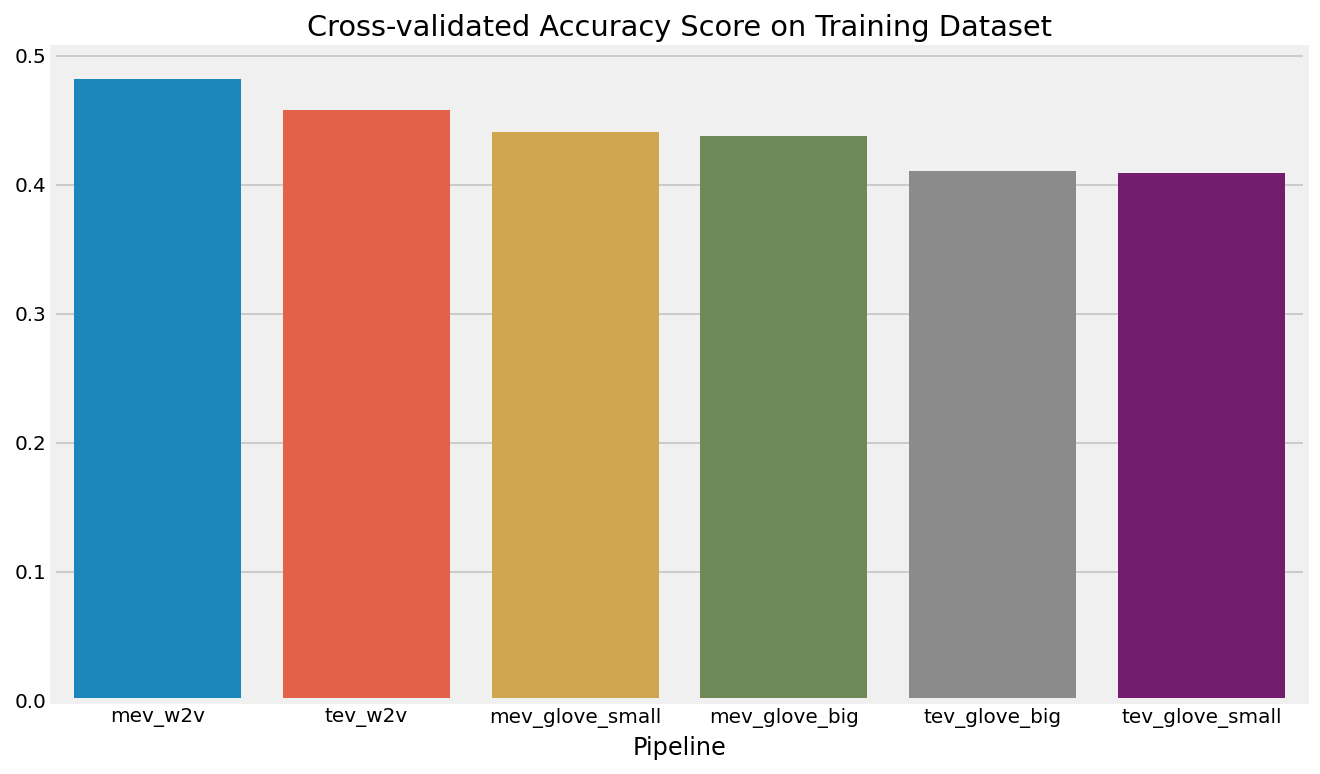

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores]);
plt.title("Cross-validated Accuracy Score on Training Dataset")
plt.xlabel("Pipeline");

<div class="alert alert-block alert-info">
    As shown above, the <b>Mean Embedding Vectorizer</b> (mev) performs best together with the <b>Word2Vec</b> (w2v) word embedding based on the training dataset vocabulary, as it scores the highest in terms of the cross-validated accuracy score.<br>

We now evaluate two options for identifying the right classifier - a Forward Neural Network (FNN) and an Extra Trees Classifier.
</div>

### Finding the best classifier

**Creation of (Inner) Training and Validation Datasets**

From our single training data set (X and y) we will create two separate datasets:
- (Inner) Training Dataset: this will be used to train our models (this will take 75% of the original training dataset)
- Validation Dataset: this will be used to validate our trained models (e.g. check for overfitting) (this will take 25% of our total 'posts' dataset

To create our datasets, we use train_test_split with the stratify option to ensure a consistent mix of values for the target feature within the created datasets.

In [108]:
# Restore the original predictor and target dataframes
X = X_original.copy()
y = y_original.copy()

In [109]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [110]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2490, 4323), (2490,), (831, 4323), (831,))

In [111]:
# Reset the indices to prevent spurious rows from appearing later during merging
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)

**Generation of word embeddings**

In [112]:
# Instantiate a Mean Embedding Vectorizer object using the Word2Vec word embeddings
mev = MeanEmbeddingVectorizer(w2v)

In [113]:
%%time
X_train_mev = mev.fit(X_train['text'], y_train)
X_train_mev = mev.transform(X_train['text'])
X_val_mev = mev.transform(X_val['text'])
X_test_mev = mev.transform(X_test['text'])

Wall time: 1min 20s


In [114]:
X_train_mev.shape, X_val_mev.shape, X_test_mev.shape

((2490, 100), (831, 100), (986, 100))

In [115]:
X_train_mev_df = pd.DataFrame(X_train_mev)
X_val_mev_df = pd.DataFrame(X_val_mev)
X_test_mev_df = pd.DataFrame(X_test_mev)

In [116]:
X_train_mev_df.shape, X_val_mev_df.shape, X_test_mev_df.shape

((2490, 100), (831, 100), (986, 100))

In [117]:
X_train_mev_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.306369,-2.858873,0.100343,-1.335620,0.764602,0.789026,-1.654341,-0.713056,-1.186841,-0.295844,...,2.547200,0.234942,-0.454785,-1.180281,0.488866,-0.714089,-0.158669,-1.036976,1.205133,1.481945
1,0.214212,-2.931701,-0.030835,-1.330592,0.930663,0.681849,-1.621763,-0.704141,-1.364626,-0.303058,...,2.570828,0.234307,-0.504451,-1.197693,0.482083,-0.673159,-0.047855,-1.036430,1.151088,1.430652
2,0.292160,-2.924828,0.016222,-1.304031,0.833340,0.686155,-1.587702,-0.641333,-1.368681,-0.412553,...,2.542941,0.198996,-0.494179,-1.223763,0.510273,-0.659935,-0.136393,-1.027767,1.291030,1.494889
3,0.233473,-2.894765,-0.032032,-1.360523,0.873460,0.691858,-1.652243,-0.718100,-1.338230,-0.373887,...,2.553179,0.251567,-0.472569,-1.235666,0.430549,-0.621494,0.021003,-1.059334,1.207182,1.412555
4,0.288591,-2.877288,0.028119,-1.381179,0.830953,0.752608,-1.609795,-0.709227,-1.307540,-0.329593,...,2.572038,0.200869,-0.482834,-1.188851,0.487425,-0.642142,-0.093983,-1.067729,1.181543,1.462555


**Combining word vectors with dummy columns**

In [118]:
# Concatenate the components parts of the dataframe
X_train = pd.concat([X_train, X_train_mev_df], axis=1)
X_val = pd.concat([X_val, X_val_mev_df], axis=1)
X_test = pd.concat([X_test, X_test_mev_df], axis=1)

In [119]:
X_train.drop(columns=['text'], inplace=True)
X_val.drop(columns=['text'], inplace=True)
X_test.drop(columns=['text'], inplace=True)

In [120]:
X_train.shape, X_val.shape, X_test.shape

((2490, 4422), (831, 4422), (986, 4422))

In [121]:
X_train.head()

,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,gene_AGXT,gene_AKAP9,gene_AKT1,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,2.547200,0.234942,-0.454785,-1.180281,0.488866,-0.714089,-0.158669,-1.036976,1.205133,1.481945
1,0,0,0,0,0,0,0,0,0,0,...,2.570828,0.234307,-0.504451,-1.197693,0.482083,-0.673159,-0.047855,-1.036430,1.151088,1.430652
2,0,0,0,0,0,0,0,0,0,0,...,2.542941,0.198996,-0.494179,-1.223763,0.510273,-0.659935,-0.136393,-1.027767,1.291030,1.494889
3,0,0,0,0,0,0,0,0,0,0,...,2.553179,0.251567,-0.472569,-1.235666,0.430549,-0.621494,0.021003,-1.059334,1.207182,1.412555
4,0,0,0,0,0,0,0,0,0,0,...,2.572038,0.200869,-0.482834,-1.188851,0.487425,-0.642142,-0.093983,-1.067729,1.181543,1.462555


**Handling of imbalanced classes**

In [122]:
y_train.value_counts(normalize=True)

7    0.287149
4    0.206426
1    0.171084
2    0.136145
6    0.082731
5    0.072691
3    0.026908
9    0.011245
8    0.005622
Name: class, dtype: float64

In [123]:
y_train.value_counts()

7    715
4    514
1    426
2    339
6    206
5    181
3     67
9     28
8     14
Name: class, dtype: int64

In [124]:
# Instantiate a SMOTE object to oversample minority classes
sm = SMOTE(random_state=42, sampling_strategy={3:100, 9:100, 8:100})

In [125]:
%%time
X_train, y_train = sm.fit_sample(X_train, y_train)

Wall time: 10.5 s


In [126]:
X_train.shape, y_train.shape

((2681, 4422), (2681,))

In [127]:
y_train.value_counts()

7    715
4    514
1    426
2    339
6    206
5    181
9    100
3    100
8    100
Name: class, dtype: int64

**Evaluating Classifier Option #1: Forward Neural Network (FNN)**

In [251]:
# replace y with categorical features
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [252]:
# remove the first column because it is redundant
y_train_cat = np.delete(y_train_cat, 0, axis=1) 
y_val_cat = np.delete(y_val_cat, 0, axis=1) 

In [253]:
y_train_cat.shape, y_val_cat.shape

((2681, 9), (831, 9))

In [291]:
def model_func(layer_one_neurons=2000, layer_one_dropout=0.2,
               layer_two_neurons=1000, layer_two_dropout=0.2, opt_learning_rate=0.01):
    model = Sequential()
    model.add(Dense(layer_one_neurons,activation='relu',input_dim=X_train.shape[1]))
    model.add(Dropout(layer_one_dropout))
    model.add(Dense(layer_two_neurons,activation='relu'))
    model.add(Dropout(layer_two_dropout))
    model.add(Dense(9,activation='softmax'))
    Ad = optimizers.Adam(learning_rate=opt_learning_rate,beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy',optimizer=Ad,metrics=['accuracy'])
    return model

In [292]:
nn = KerasClassifier(build_fn=model_func, epochs=30, verbose=2)

In [293]:
pipe= Pipeline([
    ('nn',nn)
])

In [ ]:
%%time
params={
    'nn__layer_one_neurons' : [1500, 2000, 2500],
    'nn__layer_one_dropout': [0.1, 0.2, 0.3],
    'nn__layer_two_neurons' : [500, 1000, 1500],
    'nn__layer_two_dropout': [0.1, 0.2, 0.3],
    'nn__epochs' : [10, 20, 30],
    'nn__opt_learning_rate' : [0.01, 0.001]
}
rs = RandomizedSearchCV(pipe, param_distributions = params, verbose=1, n_jobs=4, cv=3, random_state=42)
rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [196]:
# history = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=50, batch_size=512, verbose=0)

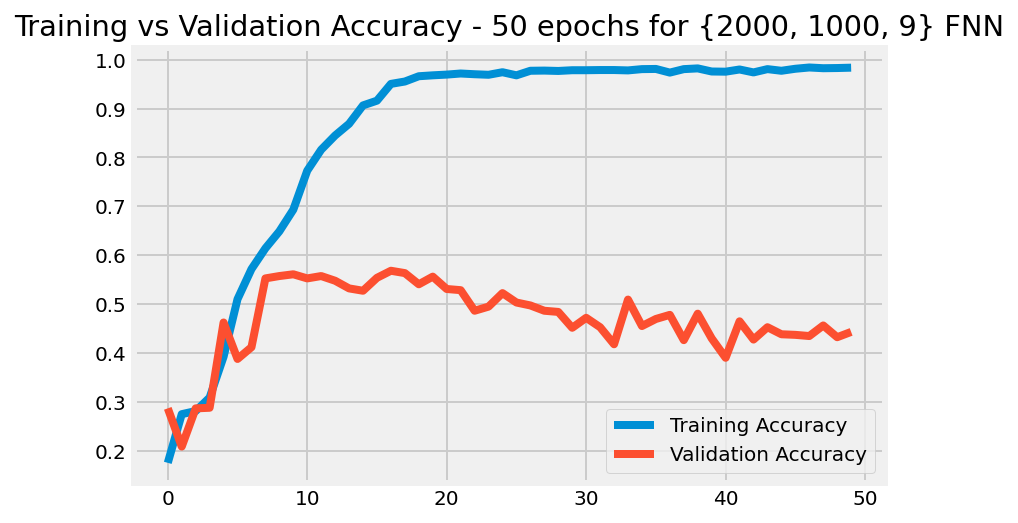

In [197]:
plt.title("Training vs Validation Accuracy - 50 epochs for {2000, 1000, 9} FNN")
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend();

We observe that the validation accuracy starts to diminish after approx. epoch 15 or so, which suggests that overfitting starts to occur after that point.

In [236]:
# We determine the highest validation accuracy and the corresponding epoch
history_df = pd.DataFrame(history.history['val_accuracy'], columns=['val_accuracy'])
history_df.index += 1
history_df.reset_index(inplace=True)
history_df['val_accuracy'].sort_values(ascending=False).head(1)

16    0.56799
Name: val_accuracy, dtype: float64

We see above that epoch 16 gives the highest validation accuracy.

**Evaluating Classifier Option #2: Extra Trees Classifier**

To manage the total time and resources used to tune the classifier parameters, we use the RandomizedSearchCV to find the optimum parameters for the Extra Trees classifier to give the best 3-way cross-validated accuracy score on the training set, within a maximum of 10 iterations. We did not consider other classifiers due to the limitations of processing power and memory. Additional classifiers could be evaluated as a next step to this Capstone project, akin to the range of classifiers that were evaluated to find the baseline classifier.

In [59]:
# We have selected the models below for modelling purposes.
estimators = {
    'etree': ExtraTreesClassifier(random_state=42),
}.items()

In [32]:
params = {
    'etree': {
        'etree__n_estimators': [150, 200, 250],
        'etree__max_features': ['auto', 'sqrt', 'log2', None],
        'etree__min_samples_split': [4, 6, 8],
        'etree__min_samples_leaf': [2, 3, 4]
    }
}

We now use RandomizedSearchCV to select the optimal parameters for each classifier that produces the best mean cross-validated accuracy score based on the training dataset.

In [33]:
%%time
# initialise empty lists to store information later
models = []
parameters = []
train_accuracy = []
val_accuracy = []
best_score = []
train_roc_auc = []
val_roc_auc = []
sensitivity = []

for k,v in estimators:
    pipe = Pipeline([(k,v)])
    param = params[k]
    randomsearch = RandomizedSearchCV(
        n_iter=10, # we set a max. of 10 iterations
        estimator=pipe,
        random_state=42,
        param_distributions=param,
        verbose=1,
        cv= 5,
        # We limit the no. of jobs to ensure sufficient memory for successful execution
        n_jobs=-1,
        return_train_score= True,
        # RandomizedSearchCV will use best cross-validation accuracy score to determine best parameters
        scoring = 'accuracy' 
    )

    randomsearch.fit(X_train, y_train)
    
    model = randomsearch.best_estimator_
    cv_score = randomsearch.cv_results_
    best_params = randomsearch.best_params_

    # predict y
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # print results
    print ("Model: ", k)
    print ("Best parameters:", best_params)
    print ("Best accuracy cross validation score:", randomsearch.best_score_)
    print ("Training dataset accuracy:", accuracy_score(y_train,y_pred_train))
    print ("Validation dataset accuracy:", accuracy_score(y_val,y_pred_val))
    print ("")
    
    # append info to list
    models.append(k)
    best_score.append(randomsearch.best_score_)
    parameters.append(best_params)
    train_accuracy.append(accuracy_score(y_train,y_pred_train))
    val_accuracy.append(accuracy_score(y_val,y_pred_val))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.2min finished


Model:  etree
Best parameters: {'etree__n_estimators': 250, 'etree__min_samples_split': 4, 'etree__min_samples_leaf': 2, 'etree__max_features': None}
Best accuracy cross validation score: 0.6614457831325302
Training dataset accuracy: 0.9072289156626506
Validation dataset accuracy: 0.6678700361010831

Wall time: 5min 54s


In [34]:
# Produce a summary table of the tuned classifier(s)
summary = pd.DataFrame({
    'model': models,
    'parameters': parameters,
    'Best accuracy cross validation score': best_score,
    'Training dataset accuracy': train_accuracy,
    'Validation dataset accuracy': val_accuracy
    })

pd.set_option('display.max_colwidth', None)
summary.sort_values('Validation dataset accuracy', ascending=False).reset_index(drop=True)

,model,parameters,Best accuracy cross validation score,Training dataset accuracy,Validation dataset accuracy
0,etree,"{'etree__n_estimators': 250, 'etree__min_samples_split': 4, 'etree__min_samples_leaf': 2, 'etree__max_features': None}",0.661446,0.907229,0.66787


### Further Exploration of Alternative Model

In [ ]:
# We instantiate the best classifier based on the best parameters found above
etree_best = ExtraTreesClassifier(verbose=1, n_jobs=-1, random_state=42, 
                                  n_estimators=250, min_samples_split=4, 
                                  min_samples_leaf=2, max_features=None)

In [ ]:
%%time
# Fit the best classifier on the training dataset
etree_best.fit(X_train, y_train)

In [ ]:
# Generate predictions
y_val_pred = etree_best.predict(X_val)

### ROC Curve & Metrics

In [38]:
# Binarize the output
y_train_binarized = label_binarize(y_train, classes=list(np.unique(y)))
y_val_pred_binarized = label_binarize(y_val_pred, classes=list(np.unique(y)))
n_classes = len(np.unique(y))

In [39]:
%%time
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=42, verbose=1), n_jobs=-1)
y_score = classifier.fit(X_train, y_train_binarized).decision_function(X_val)

Wall time: 1h 33min 37s


In [40]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # we compare our predicted labels for the validation dataset and the actual validation dataset labels
    fpr[i], tpr[i], _ = roc_curve(y_val_pred_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_pred_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

We plot ROC curves for all the 9 classes.

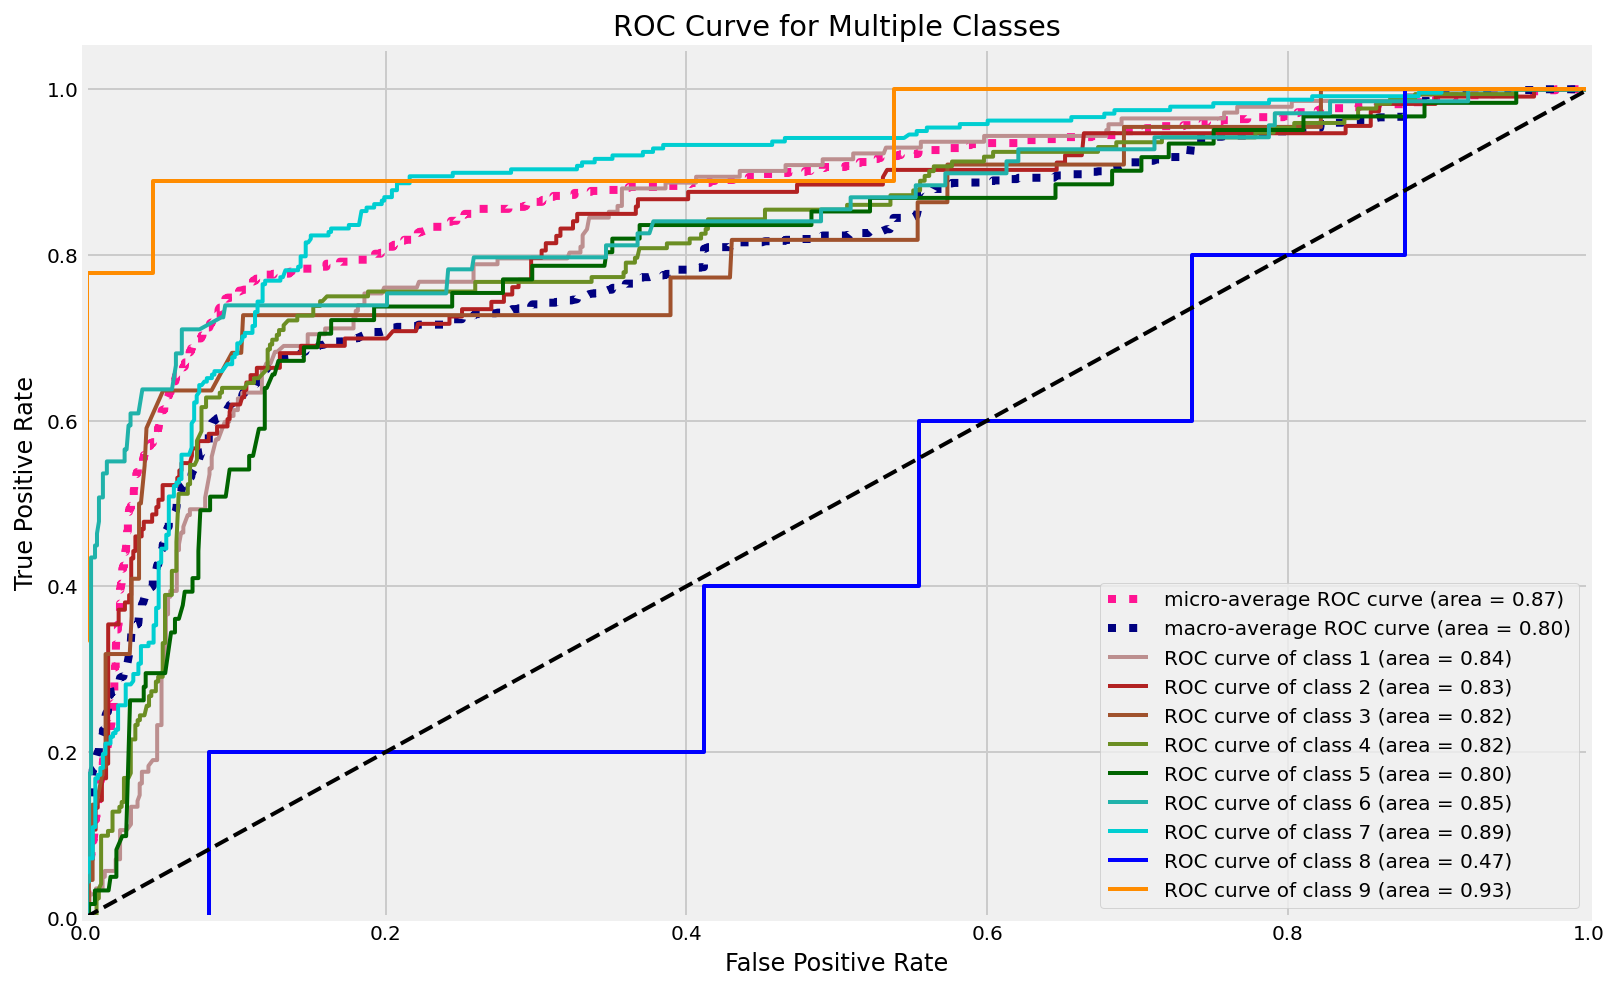

In [42]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['rosybrown', 'firebrick', 'sienna', 'olivedrab', 'darkgreen',\
                'lightseagreen', 'darkturquoise', 'b', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiple Classes')
plt.legend(loc="lower right")
plt.show()

We note from the AUC scores ('area' metric) in the plot above that class 7 (the most predominant class in the training dataset) has a high AUC score relative to the other classes, which is not surprising. The AUC score for class 8, however, is very low. 

In [43]:
%%time
y_prob = classifier.predict_proba(X_val)

Wall time: 7min 15s


In [46]:
# Calculate the average unweighted AUC of all pairwise combinations of classes (one-vs-one);
# insensitive to class imbalance
macro_roc_auc_ovo = roc_auc_score(y_val_binarized, y_prob, multi_class="ovo",
                                  average="macro")

# Calculate the weighted average AUC of all pairwise combinations of classes (one-vs-one);
# sensitive to class imbalance by considering the no. of true instances for each label
weighted_roc_auc_ovo = roc_auc_score(y_val_binarized, y_prob, multi_class="ovo",
                                     average="weighted")

# Caclulate the unweighted AUC of each class against the rest;
# still sensitive to class imbalance because the imbalance affects the composition of each of the ‘rest’ groupings
macro_roc_auc_ovr = roc_auc_score(y_val_binarized, y_prob, multi_class="ovr",
                                  average="macro")

# Caclulate the weighted AUC of each class against the rest; sensitive to class imbalance
weighted_roc_auc_ovr = roc_auc_score(y_val_binarized, y_prob, multi_class="ovr",
                                     average="weighted")

print("One-vs-One ROC AUC scores for validation dataset:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores for validation dataset:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores for validation dataset:
0.804710 (macro),
0.842587 (weighted by prevalence)
One-vs-Rest ROC AUC scores for validation dataset:
0.804710 (macro),
0.842587 (weighted by prevalence)


<div class="alert alert-block alert-info">
    <b><h3>Evaluation Outcome</h3></b>

Comparing the validation dataset accuracy, we have:
- 0.56799 for FNN
- 0.66787 for the Extra Trees Classifier

Based on the highest score above, our best alternative model based on static word embeddings is therefore the **Extra Trees classifier** trained on **Word2Vec word embeddings** using the **Mean Embedding Vectorizer**.

We note that the validation (dataset) accuracy of this model (0.66787) **has yielded a better result** than the baseline model (0.65945), suggesting that it is less overfitted compared to the baseline model. We now generate predictions and obtain the Kaggle score for our best model.
</div>

### Generation of Predictions

In [37]:
# We instantiate the best classifier based on the best parameters found above
etree_best = ExtraTreesClassifier(verbose=1, n_jobs=-1, random_state=42, n_estimators=250,\
                                  min_samples_split=4, min_samples_leaf=2, max_features=None)

In [38]:
%%time
# Fit the best classifier on the training dataset
etree_best.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.5s


Wall time: 41.8 s


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   41.1s finished


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features=None,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=2, min_samples_split=4,
                     min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=1,
                     warm_start=False)

In [62]:
y_test_pred = etree_best.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    0.2s finished


In [63]:
y_test_pred.shape, X_test.shape

((986,), (986, 4422))

In [64]:
# Restore the 'id' column since we need this for the Kaggle submission
test_pred = pd.concat([test['id'], pd.DataFrame(y_test_pred, columns=['class'])], axis=1)

In [65]:
# Verify that we have a mix of predictions for variation classes
test_pred['class'].value_counts()

7    578
4    161
1    112
2     72
5     30
6     20
3      7
9      5
8      1
Name: class, dtype: int64

In [66]:
test_pred.head()

,id,class
0,1,7
1,2,1
2,3,7
3,4,4
4,5,7


In [67]:
# We export the predictions
test_pred.to_csv("../assets/test_pred.csv", index=False)

## Evaluation of Contextualised Word Embeddings

We now turn our attention to the use of contextualised word embeddings - in particular ELMo (Embeddings from Language Models) - to determine their usefulness in our classification problem.

## Tokenisation using BERT

In [13]:
X.head()

,id,text,gene_ABL1,gene_ACVR1,gene_AGO2,gene_AKT1,gene_AKT2,gene_AKT3,gene_ALK,gene_APC,...,variation_Y87N,variation_Y901C,variation_Y931C,variation_Y98H,variation_Y98N,variation_YAP1-FAM118B Fusion,variation_YAP1-MAMLD1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_p61BRAF
0,0,cyclin dependent kinase cdks regulate variety ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,abstract background non small lung cancer nscl...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,abstract background non small lung cancer nscl...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,recent evidence ha demonstrated acquired unipa...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,oncogenic monomeric casitas b lineage lymphoma...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

In [15]:
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [17]:
# Tokenisation
tokenized = X['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (5876 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4913 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4913 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5004 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5143 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (3934 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1309 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3934 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6807 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1717 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (14368 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3428 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4581 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3428 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5716 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (40931 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4387 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4863 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12150 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (28380 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (5492 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2327 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11925 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2710 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7091 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (12412 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5366 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11796 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15530 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12935 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence lengt

Token indices sequence length is longer than the specified maximum sequence length for this model (8842 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12886 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3288 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12935 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (3929 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2188 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15388 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2684 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (2965 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10758 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5266 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15854 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6900 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (5405 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3802 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4009 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11467 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7457 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (8664 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5005 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6428 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7457 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12968 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (5819 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6752 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5838 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9166 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (12357 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6901 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4771 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4151 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6901 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (1514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (25336 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10359 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4005 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (37431 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (10005 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1978 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2123 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (28971 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4284 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (13683 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11810 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (23757 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10861 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6083 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11784 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9212 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (5925 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10412 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5925 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1841 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5925 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (6666 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10794 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15622 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1368 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (16580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (10625 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3242 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4109 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5757 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3688 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (5013 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8411 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3374 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5037 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8870 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (4723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3777 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10139 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4239 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (3661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10272 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (10621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (3248 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3823 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10104 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15916 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2553 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (13364 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3698 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4274 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6920 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4976 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (4360 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8283 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5090 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4262 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12750 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (4511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11108 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (24054 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4499 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (17918 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (18507 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (29936 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence lengt

Token indices sequence length is longer than the specified maximum sequence length for this model (12943 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12890 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9785 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9785 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (5044 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4663 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3257 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4663 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3084 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (3474 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4348 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4348 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13645 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (14498 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (1697 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7448 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8286 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10058 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7448 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (16301 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (26847 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3694 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11882 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3946 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (5883 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6538 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5883 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3672 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4863 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (4253 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11965 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5043 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6107 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6806 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (5704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5704 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6478 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5011 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3836 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (3697 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (23585 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6387 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4362 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2556 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (9891 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4362 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (14418 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4362 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4362 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (4601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7509 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (36575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (12705 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9907 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9907 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (18050 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9907 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (3703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5461 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (1357 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11740 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6185 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (5743 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4490 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (18387 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6870 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6064 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (4772 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7721 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (22265 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5237 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6946 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (39095 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13157 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11316 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (31171 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (39860 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

Token indices sequence length is longer than the specified maximum sequence length for this model (10454 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10454 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9985 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10454 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (16606 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence lengt

Token indices sequence length is longer than the specified maximum sequence length for this model (4601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7179 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1345 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5493 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (8009 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3801 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (16448 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5493 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5493 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (3801 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13794 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3801 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5493 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (9608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4320 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15301 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4320 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9700 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (6921 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6921 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (19176 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (22363 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6921 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (5816 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4440 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8816 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3701 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5816 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (8264 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6335 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9225 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9247 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13818 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (13726 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6342 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10707 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (15502 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (10554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7205 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13229 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4759 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6342 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (5690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4212 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2103 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (17467 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9879 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11884 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (6615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3264 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8847 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8102 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (2926 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3380 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7813 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (7813 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1946 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (5371 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9107 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10403 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4328 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4304 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2633 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4414 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4414 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9295 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (5260 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6662 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2652 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4010 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (9593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (1302 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (13501 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6103 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5217 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (46065 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (16715 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4731 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (41525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (19804 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence lengt

Token indices sequence length is longer than the specified maximum sequence length for this model (1651 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (22302 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3153 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1911 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3234 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

Token indices sequence length is longer than the specified maximum sequence length for this model (14611 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2852 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2067 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3157 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12031 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (24922 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (10220 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8532 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11998 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6220 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (10759 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (9625 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (8654 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (24509 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (17241 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length

Token indices sequence length is longer than the specified maximum sequence length for this model (1081 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (38150 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2665 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12153 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length 

Token indices sequence length is longer than the specified maximum sequence length for this model (4051 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (5090 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1411 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (6425 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4961 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length fo

Token indices sequence length is longer than the specified maximum sequence length for this model (9102 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# Padding
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

In [ ]:
# Masking
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

In [ ]:
# Running our Model
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
X = pd.concat([pd.DataFrame(last_hidden_states[0][:,0,:].numpy()), X], axis=1)
X.drop(columns='text', inplace=True)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [14]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2490, 3262), (2490,), (831, 3262), (831,))

In [15]:
X_train.reset_index(inplace=True)
X_val.reset_index(inplace=True)